# Import Torch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report
import numpy as np

# Download training & Test Data

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.28MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.0MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.46MB/s]


# Create data loaders

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Creating Models

In [4]:
import torch
import torch.nn as nn

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_leakyrelu_stack = nn.Sequential(
            nn.Linear(28*28, 250),
            nn.BatchNorm1d(250),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),  # Added dropout
            nn.Linear(250, 125),
            nn.BatchNorm1d(125),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),  # Added dropout
            nn.Linear(125, 75),
            nn.BatchNorm1d(75),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.2),  # Added dropout
            nn.Linear(75, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_leakyrelu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_leakyrelu_stack): Sequential(
    (0): Linear(in_features=784, out_features=250, bias=True)
    (1): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=250, out_features=125, bias=True)
    (5): BatchNorm1d(125, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=125, out_features=75, bias=True)
    (9): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=75, out_features=10, bias=True)
  )
)


# Code to Check Dataset Size

In [5]:
# Print total number of samples in training and test datasets
print(f"Total training samples: {len(training_data)}")
print(f"Total test samples: {len(test_data)}")
print(f"Total dataset size: {len(training_data) + len(test_data)}")

Total training samples: 60000
Total test samples: 10000
Total dataset size: 70000


# Display Data

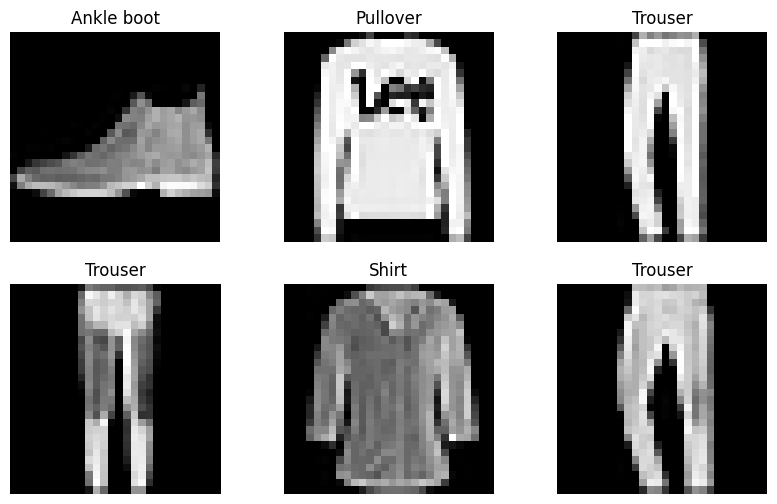

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define class labels for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get one batch of images and labels from the test dataloader
images, labels = next(iter(test_dataloader))

# Plot the first 6 images
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    # Convert tensor to numpy and remove channel dimension
    image = images[i].numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.show()

# Optimizing the Model Parameters

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Optimizing the Model using Adamoptimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

# Train Function

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
           

# Test Function

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            predictions = pred.argmax(1)
            correct += (predictions == y).type(torch.float).sum().item()
            all_preds.extend(predictions.cpu().numpy())  # Collect predictions
            all_labels.extend(y.cpu().numpy())  # Collect true labels
    
    test_loss /= num_batches
    correct /= size
    
    # Generate classification report
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Train Data

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.434986 

Classification Report:

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.82      0.81      1000
     Trouser       0.99      0.94      0.97      1000
    Pullover       0.83      0.57      0.67      1000
       Dress       0.86      0.87      0.87      1000
        Coat       0.73      0.70      0.72      1000
      Sandal       0.98      0.86      0.92      1000
       Shirt       0.53      0.72      0.61      1000
     Sneaker       0.88      0.94      0.91      1000
         Bag       0.95      0.97      0.96      1000
  Ankle boot       0.91      0.95      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.383253 

Classification Report:

         